In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pesq import pesq
import pystoi
import pandas as pd

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance, calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from data_generators import NoisyTargetWithMetricsGenerator
from sound import Sound
import tensorflow.keras.backend as K

In [3]:
base_shape_size = 8192
ws = 255
ol = 128

In [4]:
sound_base = Sound('../../../Dados/Vozes/', '../../../Dados/Ruido/', base_shape_size)

Loading Noise Files: 100%|██████████| 8137/8137 [00:07<00:00, 1050.62it/s]
/tf/utils/sound.py:65: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]


In [5]:
def stft_to_signal(stft, sampling_rate=8000, window_size=ws, overlap=ol):
    A = stft[..., 0]
    phi = stft[..., 1]
    signal = reconstruct_signal_from_stft(A, phi, sampling_rate=sampling_rate, window_size=window_size, overlap=overlap)

    return signal

In [6]:
data_generator = NoisyTargetWithMetricsGenerator(sound_base.train_X, sound_base.noise_sounds)

In [7]:
def process_batch(x_batch, y_batch, model):
    stfts = model.predict(x_batch, verbose=False)
    M, height, width, channels = stfts.shape  # Obtenha as dimensões do array de resultados do modelo

    pesq_scores = []
    stoi_scores = []
    snr_scores = []
    ID_scores = []

    for i in range(M):
        filtered = stfts[i, :, :, :]  # Obtenha o resultado do modelo para a iteração atual

        clean = y_batch[i, :, :, :]  # Obtenha o sinal limpo correspondente

        clean_signal = stft_to_signal(clean).reshape(-1)
        filtered_signal = stft_to_signal(filtered).reshape(-1)

        try:
            pesq_score = pesq(8000, clean_signal, filtered_signal, 'nb')
        except:
            pesq_score = 1.04
        stoi_score = pystoi.stoi(clean_signal, filtered_signal, 8000)
        snr_score = calculate_snr(clean_signal, filtered_signal)
        # ID_score = itakura_distortion(clean_signal, filtered_signal, 256, 11)

        pesq_scores.append(pesq_score)
        stoi_scores.append(stoi_score)
        snr_scores.append(snr_score)
        # ID_scores.append(ID_score)

    return pesq_scores, stoi_scores, snr_scores, ID_scores

In [8]:
batch_num = 50
df_resultado = pd.DataFrame()

In [9]:
# model = load_model('DNS-loss-0.0212-epochs-3-2023-11-11_21-09-11.h5')
model = load_model('/tf/Etapa 3/UNet/res-unet-convlstm-loss-0.0087-epochs-64-2023-11-12_14-28-26.h5')

OSError: No file or directory found at PRIDNet_loss-0.0165-epochs-54.h5

In [11]:
results = []

for _ in tqdm(range(batch_num)):
    x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_completo(batch_size=128))
    results.append((process_batch(x_batch, y_batch, model),metrics_batch_df))

df_resultado = pd.DataFrame()

for result , metrics_batch_df in results:
    pesq_scores, stoi_scores, snr_scores, ID_scores = result
    metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    metrics_batch_df['STOI (Filtered)'] = stoi_scores
    metrics_batch_df['SNR (Filtered)'] = snr_scores
    # metrics_batch_df['ID (Filtered)'] = ID_scores
    
    df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

100%|██████████| 50/50 [06:35<00:00,  7.92s/it]


In [12]:
df_resultado

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
0,3.404506,0.971211,12.869084,4.165383,0.967711,17.978601
1,2.616103,0.925950,5.864018,3.959409,0.960229,17.305560
2,1.948181,0.914727,12.184607,3.754086,0.975889,16.928301
3,2.355175,0.817615,15.312338,3.835824,0.960180,21.908562
4,2.135421,0.882059,5.968028,3.797274,0.949871,17.041998
...,...,...,...,...,...,...
6380,1.544227,0.657639,4.958706,2.897505,0.808807,9.951025
6381,2.003290,0.793413,11.655519,3.489834,0.921219,13.445034
6382,2.585248,0.736953,8.892429,3.533244,0.826019,13.125764
6383,2.692894,0.728928,21.867175,3.849597,0.830815,12.715932


In [13]:
df_resultado.describe()

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
count,6385.000000,6385.000000,6385.000000,6385.000000,6385.000000,6385.000000
mean,2.131469,0.841791,9.274789,3.243787,0.895420,13.275474
std,0.566500,0.134195,5.717484,0.619926,0.106304,4.101004
min,1.059867,0.120915,-0.119195,1.040000,0.142006,-0.141804
25%,1.700897,0.772358,3.986128,2.824360,0.864578,9.975041
50%,2.058127,0.879980,8.951162,3.327572,0.930549,13.009043
75%,2.483702,0.945340,13.946954,3.748107,0.966584,16.409833
max,4.490897,0.999277,29.089477,4.402803,0.998291,26.452260


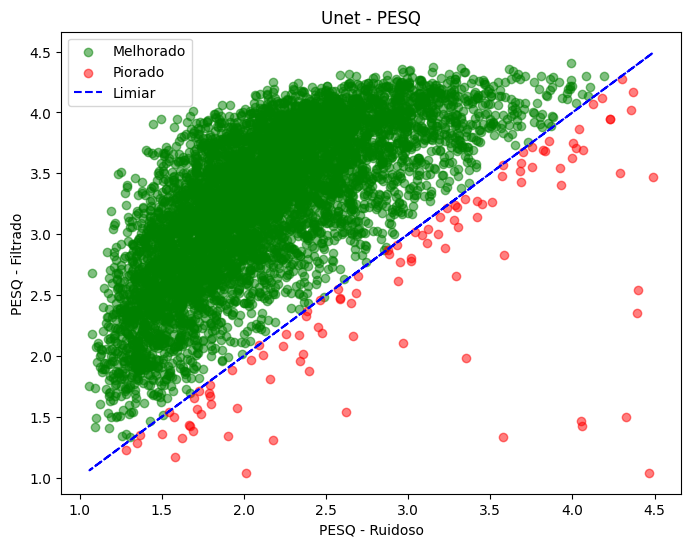

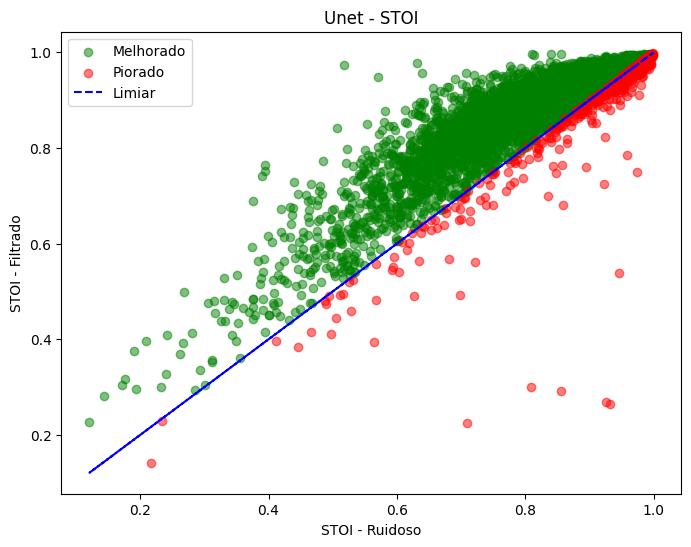

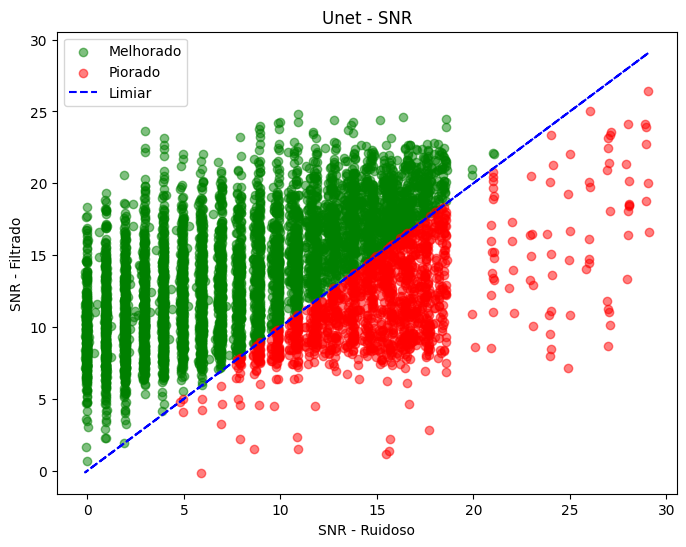

KeyError: 'ID'

<Figure size 800x600 with 0 Axes>

In [14]:
performance(df_resultado, 'Unet')

In [15]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Define the file name with the datetime
file_name = f"ResUnetConvLSTM-metrics_{datetime_str}.xlsx"

In [16]:
df_resultado.to_excel(file_name, index=False)